In [ ]:
!python3 -m venv .venv && source .venv/bin/activate && pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization


In [4]:
# Load wine quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

In [6]:
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [46]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [11]:
pd.DataFrame(data.isnull().sum())


,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


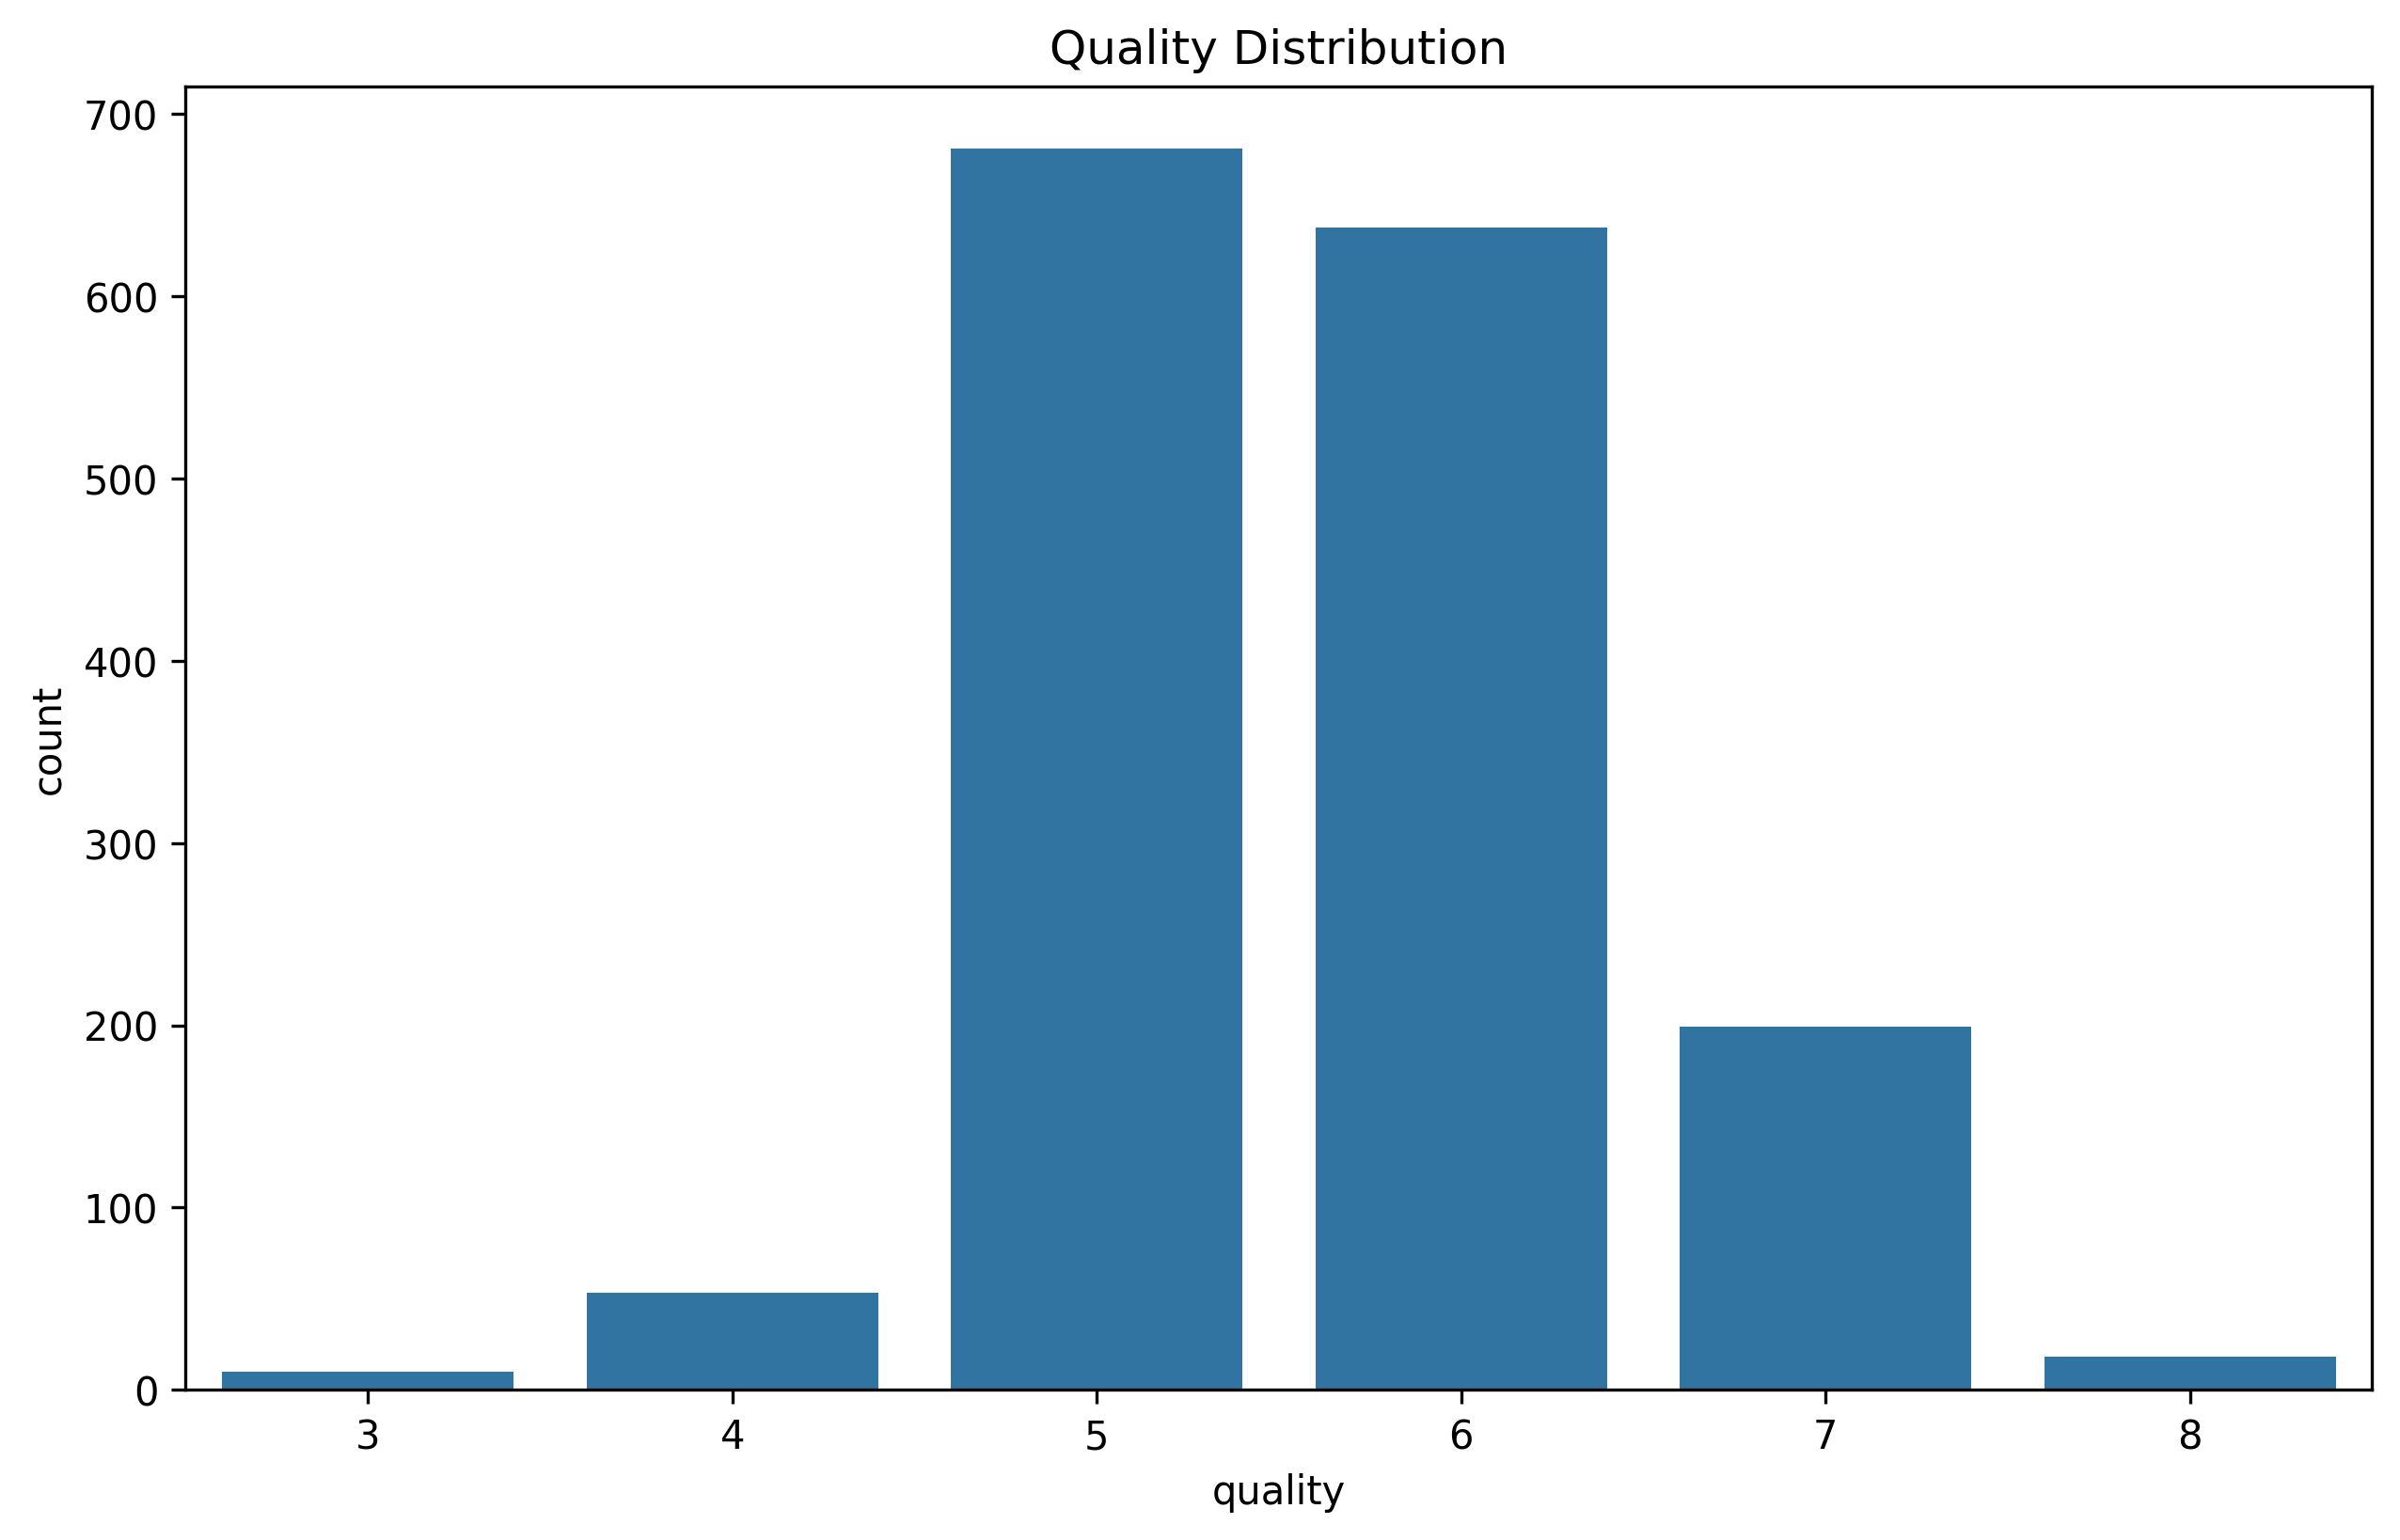

In [40]:
plt.figure(figsize=(10, 6), dpi=300)
plt.title('Quality Distribution')
sns.barplot(data['quality'].value_counts())
plt.show()


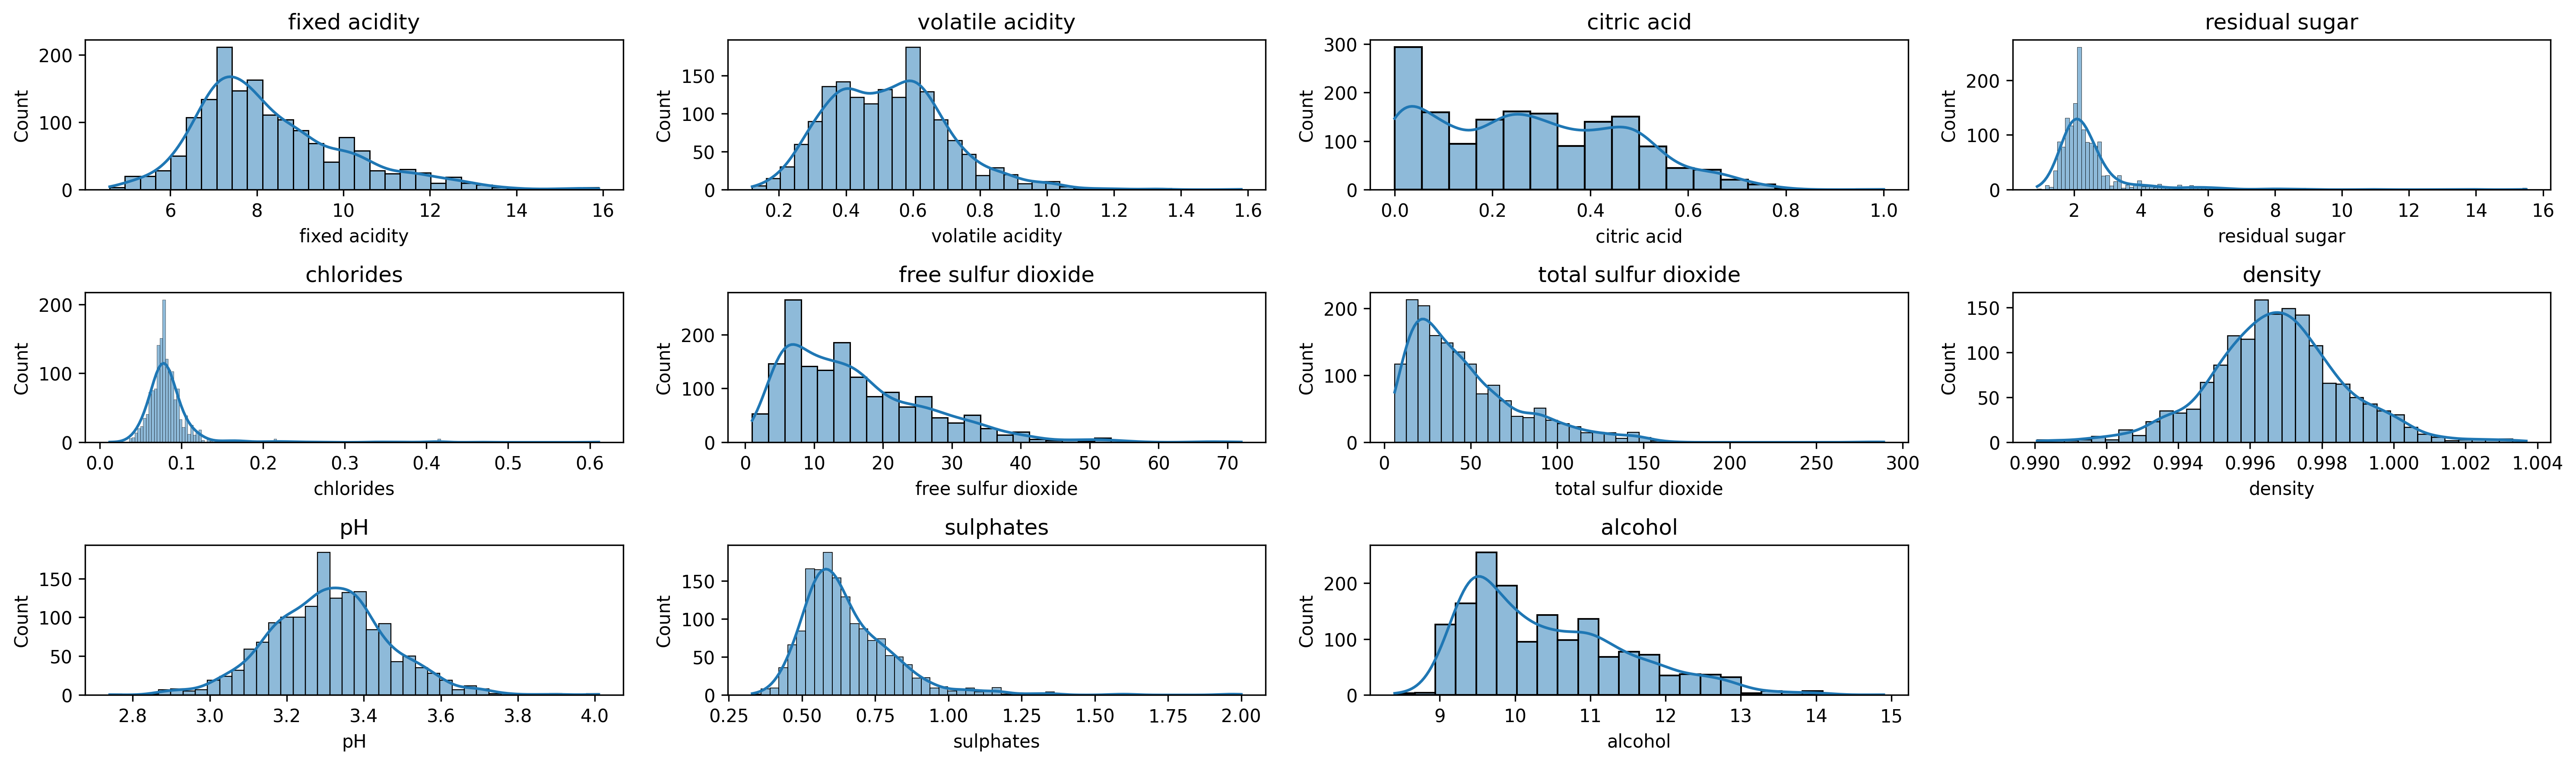

In [42]:
plt.figure(figsize=(20, 6), dpi=300)
# plot data distribution for each feature
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(3, 4, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

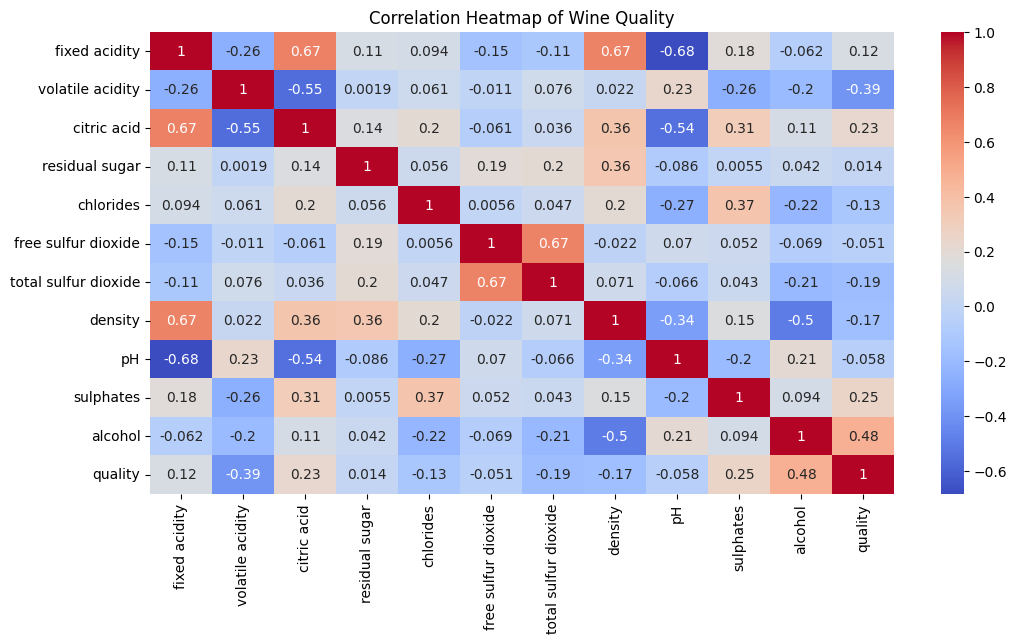

In [47]:
plt.figure(figsize=(12, 6))
plt.title('Correlation Heatmap of Wine Quality')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [48]:
X = data.drop('quality', axis=1)
y = data['quality']

In [57]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [122]:
svm_bounds = {
    'C': (1, 100),
    'gamma': (0.001, 0.1) 
}

In [118]:
# Bayesian optimization function for SVM
def svm_eval(C, gamma):
    model = SVC(C=C, gamma=gamma, random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [167]:
svm_optimizer = BayesianOptimization(f=svm_eval, pbounds=svm_bounds, random_state=42)
svm_optimizer.maximize(n_iter=100, init_points=5)
print("Best hyperparameters for SVM:", svm_optimizer.max['params'])

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.5715    | 38.08     | 0.09512   |
| 2         | 0.5692    | 73.47     | 0.06027   |
| 3         | 0.5473    | 16.45     | 0.01644   |
| 4         | 0.5684    | 6.75      | 0.08675   |
| 5         | 0.5715    | 60.51     | 0.0711    |
| 6         | 0.5645    | 38.0      | 0.05412   |
| 7         | 0.5598    | 38.23     | 0.04626   |
| 8         | 0.5622    | 11.03     | 0.05265   |
| 9         | 0.5692    | 60.47     | 0.07218   |
| 10        | 0.5802    | 60.6      | 0.001129  |
| 11        | 0.5676    | 60.7      | 0.0418    |
| 12        | 0.5708    | 44.74     | 0.08261   |
| 13        | 0.57      | 60.6      | 0.06687   |
| 14        | 0.5794    | 60.54     | 0.004416  |
| 15        | 0.5622    | 44.94     | 0.04824   |
| 16        | 0.5606    | 60.8      | 0.01602   |
| 17        | 0.5739    | 44.55     | 0.08955   |
| 18        | 0.5645    | 44.4      | 0.04233   |


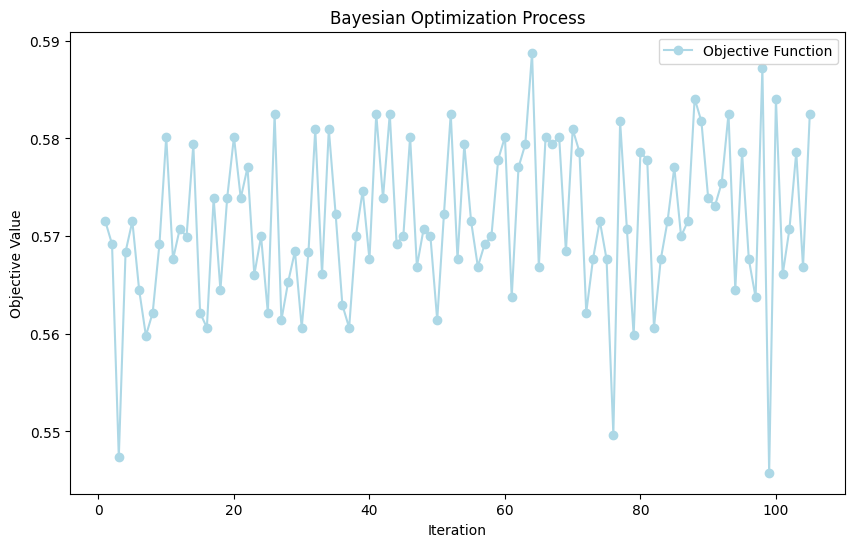

In [168]:
target_values = [res['target'] for res in svm_optimizer.res]
iterations = list(range(1, len(target_values) + 1))

# Plot the optimization process
plt.figure(figsize=(10, 6))
plt.plot(iterations, target_values, marker='o', color='lightblue', label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization Process')
plt.legend()
plt.grid(False)
plt.show()


In [123]:
gb_bounds = {
    'n_estimators': (100, 400),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3)
}

In [124]:
def gb_eval(n_estimators, max_depth, learning_rate):
    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        random_state=42
    )
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [ ]:
gb_optimizer = BayesianOptimization(f=gb_eval, pbounds=gb_bounds, random_state=42)
gb_optimizer.maximize(n_iter=100, init_points=5)
print("Best hyperparameters for Gradient Boosting:", gb_optimizer.max['params'])

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6787    | 0.1186    | 9.655     | 319.6     |
| 2         | 0.6802    | 0.1836    | 4.092     | 146.8     |
| 3         | 0.6701    | 0.02684   | 9.063     | 280.3     |
| 4         | 0.6583    | 0.2153    | 3.144     | 391.0     |
| 5         | 0.6599    | 0.2514    | 4.486     | 154.5     |
| 6         | 0.6693    | 0.1511    | 9.717     | 319.8     |
| 7         | 0.6881    | 0.05663   | 5.793     | 126.0     |
| 8         | 0.6849    | 0.1043    | 6.354     | 142.8     |
| 9         | 0.6677    | 0.2835    | 5.575     | 166.4     |
| 10        | 0.6693    | 0.2693    | 9.031     | 224.0     |
| 11        | 0.6748    | 0.1064    | 7.759     | 388.9     |
| 12        | 0.6638    | 0.03738   | 8.609     | 278.7     |
| 13        | 0.6771    | 0.1269    | 8.885     | 327.3     |
| 14        | 0.6693    | 0.187     | 4.55      | 392.8     |
| 15    

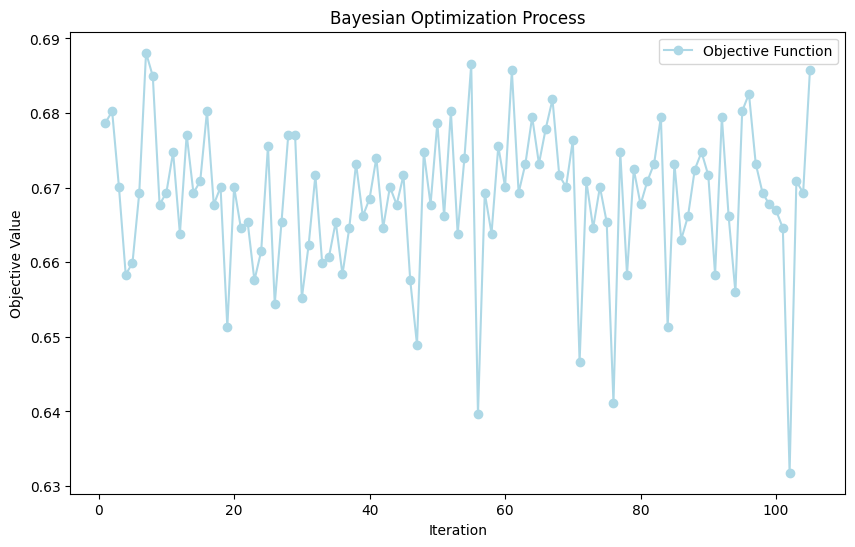

In [ ]:
target_values = [res['target'] for res in gb_optimizer.res]
iterations = list(range(1, len(target_values) + 1))

# Plot the optimization process
plt.figure(figsize=(10, 6))
plt.plot(iterations, target_values, marker='o', color='lightblue', label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization Process')
plt.legend()
plt.grid(False)
plt.show()


In [64]:
rf_bounds = {
    'n_estimators': (100, 400),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

In [126]:
def rf_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

In [ ]:
rf_optimizer = BayesianOptimization(f=rf_eval, pbounds=rf_bounds, random_state=42)
rf_optimizer.maximize(n_iter=100, init_points=5)
print("Best hyperparameters for RandomForest:", rf_optimizer.max['params'])


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6333    | 5.622     | 3.852     | 7.856     | 279.6     |
| 2         | 0.6201    | 4.092     | 1.468     | 2.465     | 359.9     |
| 3         | 0.656     | 7.208     | 3.124     | 2.165     | 391.0     |
| 4         | 0.667     | 8.827     | 1.637     | 3.455     | 155.0     |
| 5         | 0.631     | 5.13      | 2.574     | 5.456     | 187.4     |
| 6         | 0.6646    | 7.837     | 1.815     | 3.525     | 155.4     |
| 7         | 0.6662    | 10.0      | 1.0       | 2.0       | 144.1     |
| 8         | 0.6576    | 10.0      | 4.0       | 10.0      | 124.5     |
| 9         | 0.606     | 3.682     | 1.178     | 2.672     | 100.9     |
| 10        | 0.6748    | 9.143     | 1.885     | 2.272     | 233.9     |
| 11        | 0.6013    | 3.0       | 4.0       | 10.0      | 244.4     |
| 12        | 0.674     | 10.0      | 

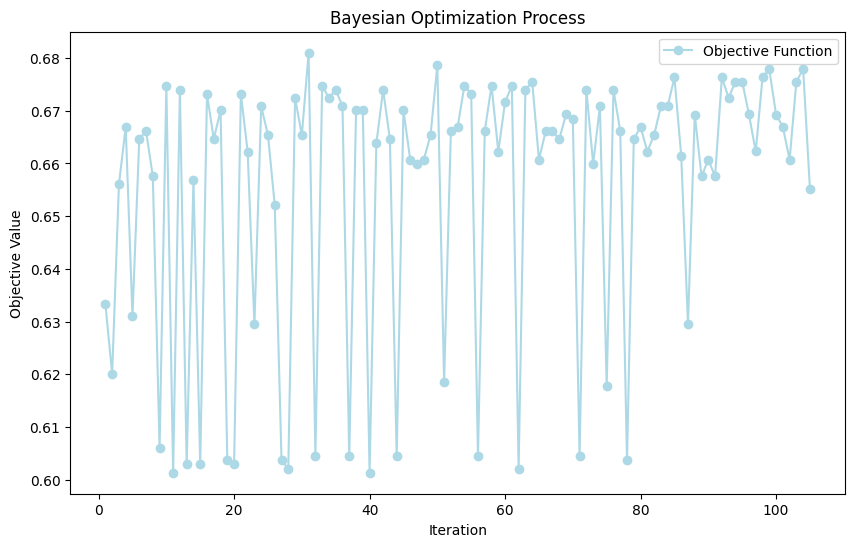

In [ ]:
target_values = [res['target'] for res in rf_optimizer.res]
iterations = list(range(1, len(target_values) + 1))

# Plot the optimization process
plt.figure(figsize=(10, 6))
plt.plot(iterations, target_values, marker='o', color='lightblue', label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization Process')
plt.legend()
plt.grid(False)
plt.show()


In [128]:
dt_bounds = {
    'max_depth': (3, 20),
    'min_samples_split': (3, 20),
    'min_samples_leaf': (3, 8)
}

In [130]:
def dt_eval(max_depth, min_samples_split, min_samples_leaf):
    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    return np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy'))

In [ ]:
dt_optimizer = BayesianOptimization(f=dt_eval, pbounds=dt_bounds, random_state=42)
n_iter: int = 100
dt_optimizer.maximize(n_iter=n_iter, init_points=5)
print("Best hyperparameters for Decision Tree:", dt_optimizer.max['params'])

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
| 1         | 0.5841    | 9.367     | 7.754     | 15.44     |
| 2         | 0.5739    | 13.18     | 3.78      | 5.652     |
| 3         | 0.5622    | 3.987     | 7.331     | 13.22     |
| 4         | 0.5723    | 15.04     | 3.103     | 19.49     |
| 5         | 0.5801    | 17.15     | 4.062     | 6.091     |
| 6         | 0.5841    | 9.404     | 7.403     | 15.39     |
| 7         | 0.5669    | 12.55     | 8.0       | 14.36     |
| 8         | 0.5809    | 8.566     | 7.189     | 17.27     |
| 9         | 0.5849    | 8.812     | 4.075     | 15.88     |
| 10        | 0.577     | 8.005     | 3.0       | 18.35     |
| 11        | 0.5802    | 9.279     | 3.0       | 13.58     |
| 12        | 0.5747    | 11.05     | 3.254     | 16.17     |
| 13        | 0.595     | 7.779     | 5.402     | 14.84     |
| 14        | 0.6005    | 6.696     | 4.352     | 14.98     |
| 15    

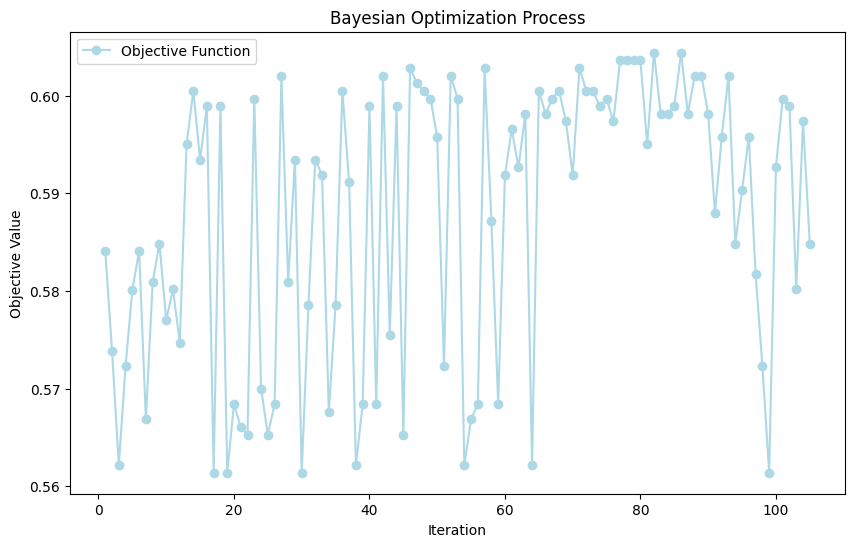

In [ ]:
target_values = [res['target'] for res in dt_optimizer.res]
iterations = list(range(1, len(target_values) + 1))

# Plot the optimization process
plt.figure(figsize=(10, 6))
plt.plot(iterations, target_values, marker='o', color='lightblue', label='Objective Function')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization Process')
plt.legend()
plt.grid(False)
plt.show()


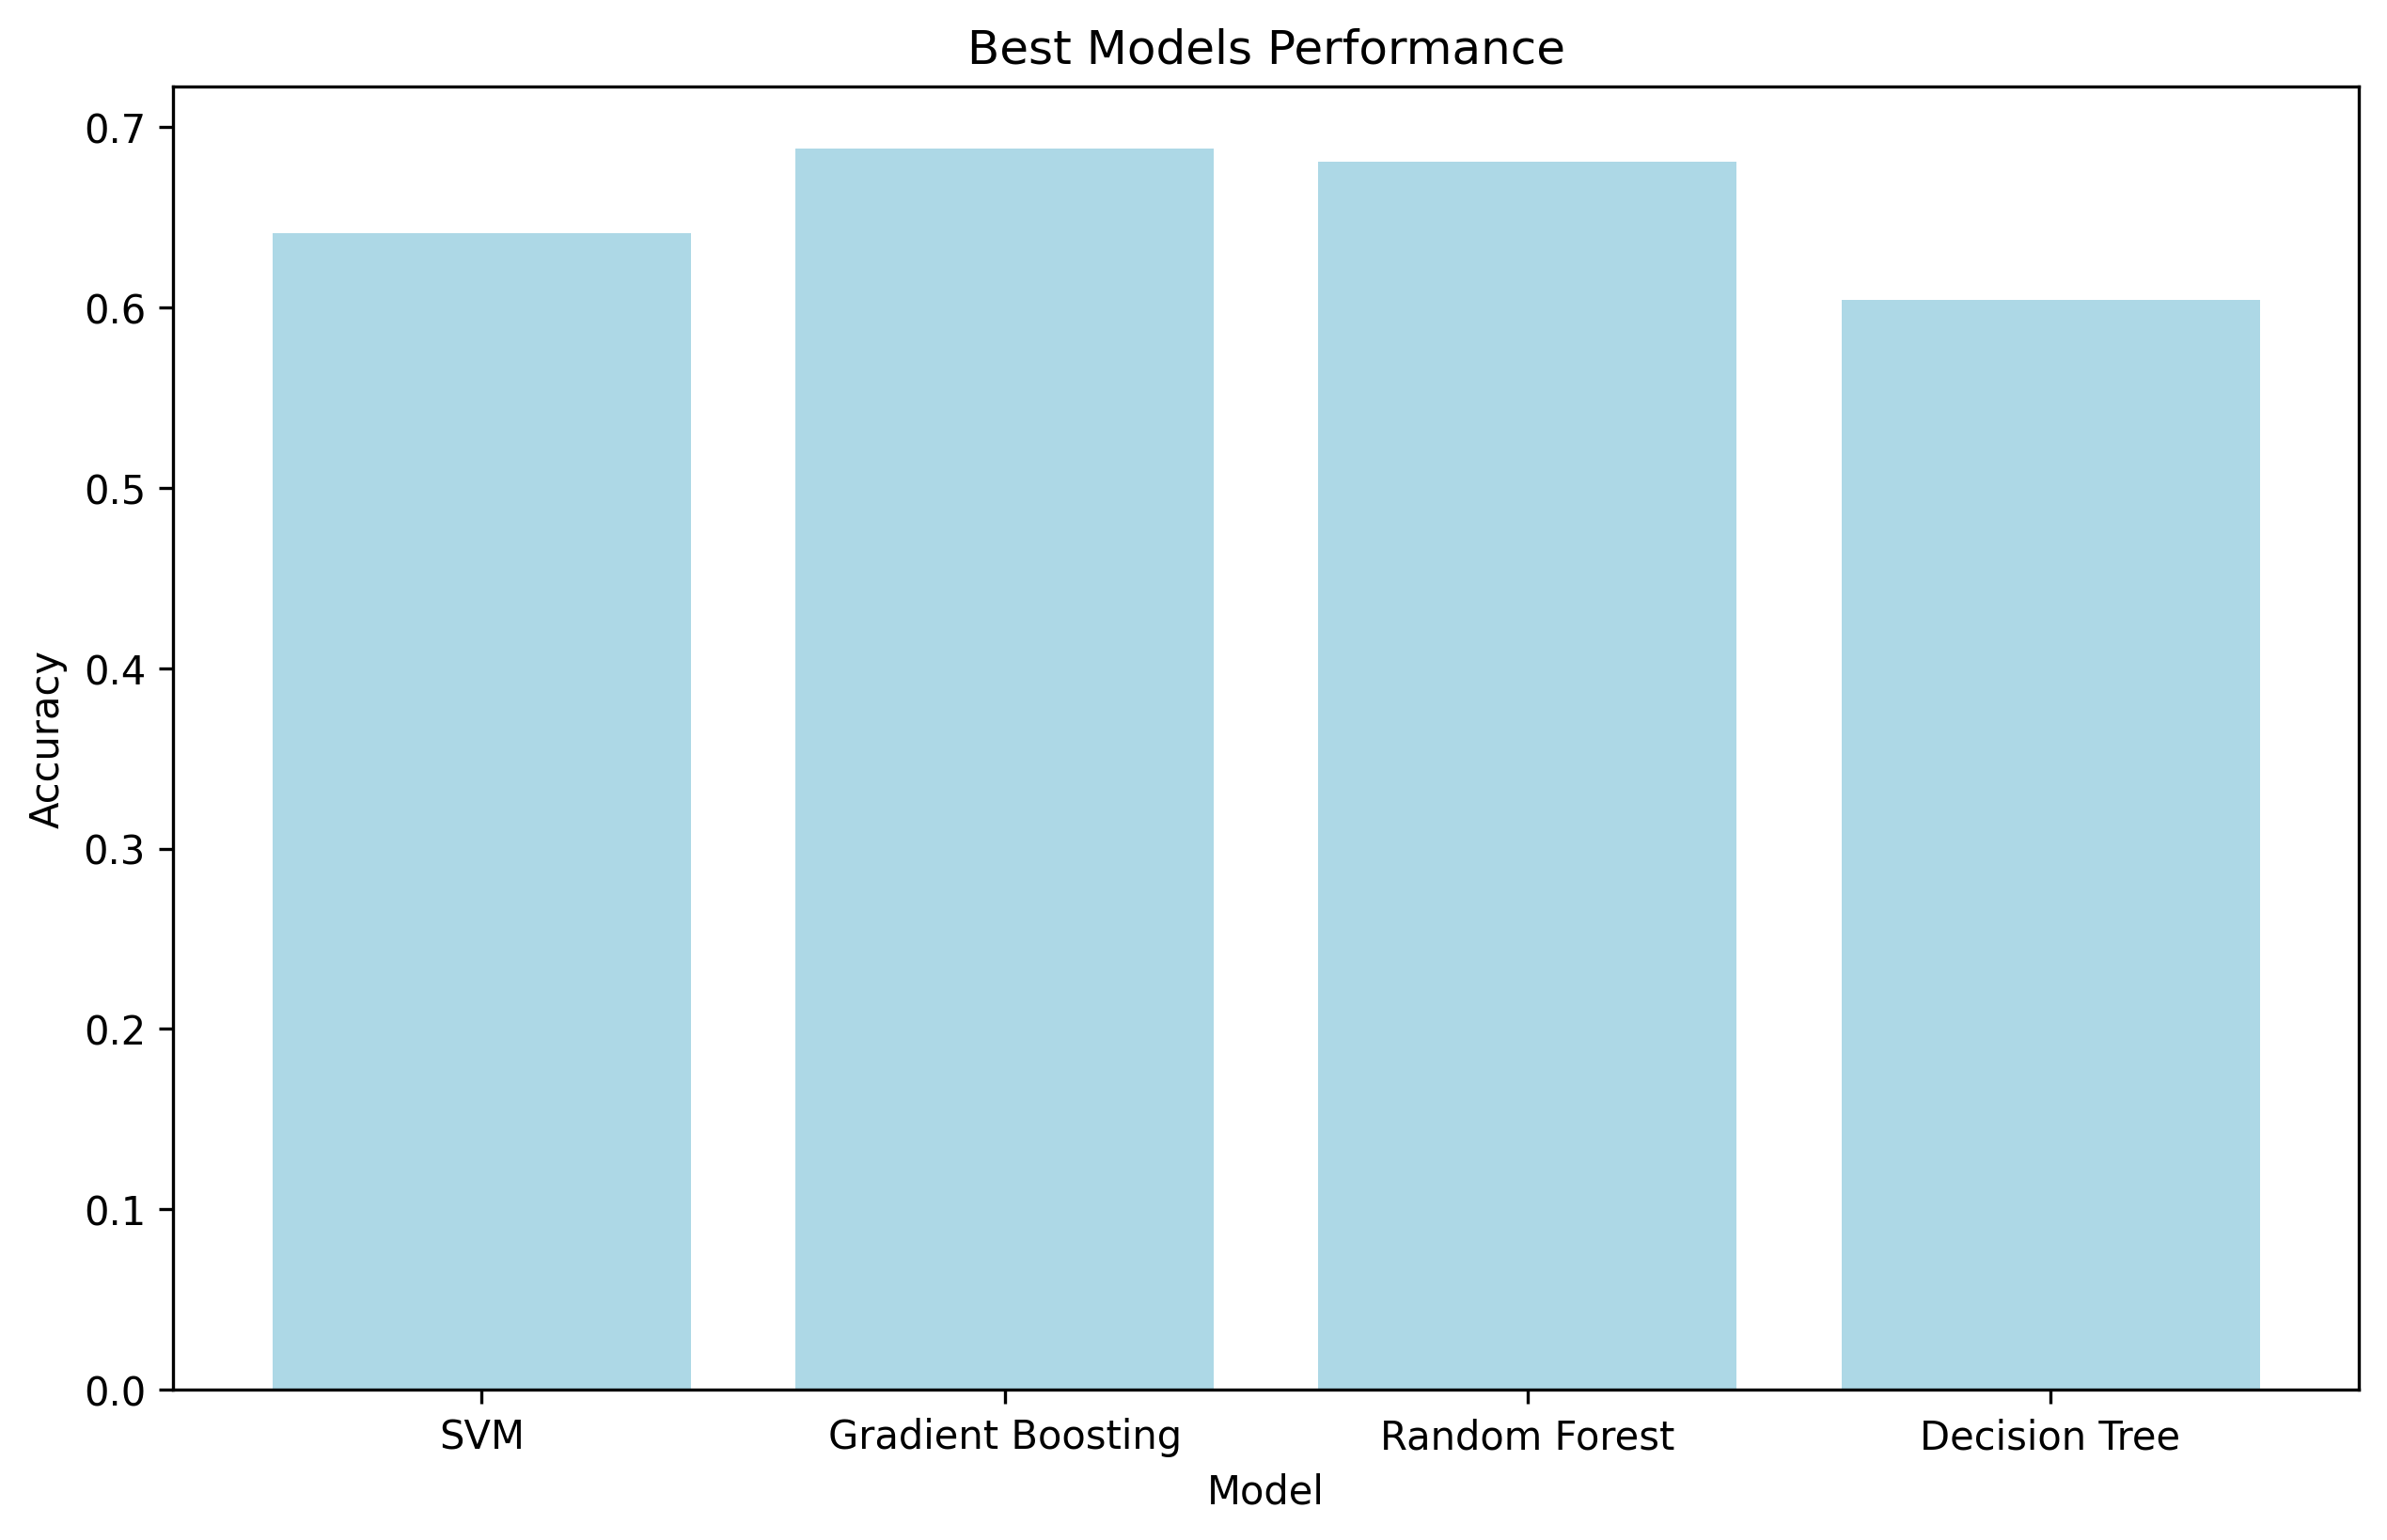

In [ ]:
models_best_results = {
    'SVM': svm_optimizer.max['target'],
    'Gradient Boosting': gb_optimizer.max['target'],
    'Random Forest': rf_optimizer.max['target'],
    'Decision Tree': dt_optimizer.max['target']
}
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(models_best_results.keys(), models_best_results.values(), color='lightblue')
plt.title('Best Models Performance')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [90]:
!pip freeze > requirements.txt